In [2]:
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [4]:
import random
random.seed(42)

In [5]:
dataset = pd.read_csv('../data/NSE.csv')
dataset = dataset.dropna()
dataset = dataset[['Open', 'High', 'Low', 'Close']]

In [6]:
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window=3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window=10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window=30).mean()
dataset['Std_dev'] = dataset['Close'].rolling(5).std()
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)
dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)

In [7]:
# Binary var storing 1 when the closing price of tomorrow is greater than todays
dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

In [8]:
dataset = dataset.dropna() #drop all the rows storing NaN

In [9]:
X = dataset.iloc[:, 4:-1] 
y = dataset.iloc[:, -1]

In [10]:
# Split our input and output to create the test and train datasets
split = int(len(dataset)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [11]:
# Feature Scaling
# make the mean of all the input features equla to zero and convert their variance
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
classifier = Sequential()

In [20]:
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [21]:
h = classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
952/952 [==============================] - 0s 284us/step - loss: 0.2307 - acc: 0.5924
Epoch 2/100
952/952 [==============================] - 0s 189us/step - loss: 0.1894 - acc: 0.7479
Epoch 3/100
952/952 [==============================] - 0s 255us/step - loss: 0.1685 - acc: 0.7752
Epoch 4/100
952/952 [==============================] - 0s 143us/step - loss: 0.1577 - acc: 0.7941
Epoch 5/100
952/952 [==============================] - 0s 144us/step - loss: 0.1572 - acc: 0.7836
Epoch 6/100
952/952 [==============================] - 0s 142us/step - loss: 0.1556 - acc: 0.7910
Epoch 7/100
952/952 [==============================] - 0s 155us/step - loss: 0.1426 - acc: 0.8120
Epoch 8/100
952/952 [==============================] - 0s 160us/step - loss: 0.1452 - acc: 0.8088
Epoch 9/100
952/952 [==============================] - 0s 144us/step - loss: 0.1407 - acc: 0.8067
Epoch 10/100
952/952 [==============================] - 0s 144us/step - loss: 0.1404 - acc: 0.8225
Epoch 11/100
952/95

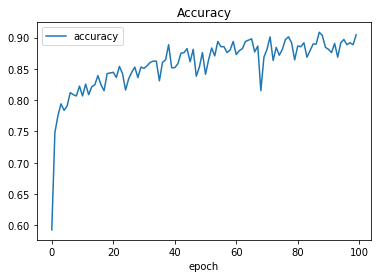

In [35]:
plt.plot(h.history['acc'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('Accuracy')
plt.show()

In [27]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [28]:
dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

In [31]:
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [32]:
trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])

/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/oasysokubo/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


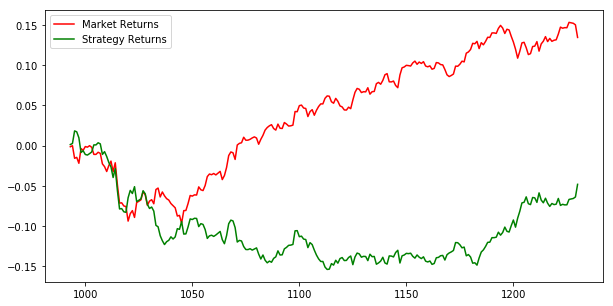

In [34]:
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()